In [2]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))

from auto_encoder.ae import AE, evaluate_ae_error, train_ae
from data_generation.utils import generate_pairs_from_indices, save_feedbacks_npz
from data_loading.extract_indices import extract_trajectory_indices
from data_loading.load_data import load_dataset
from src.auto_encoder.vae import VAE, TrajectoryPairDataset, evaluate_vae_error, train_vae
from src.utils.path import get_ae_model_path, get_vae_model_path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 환경 변수 설정
env_name = "box-close-v2"
exp_name = "AESPA-class"
pair_algo = "total"

# 하이퍼파라미터
traj_len = 25
obs_dim = 43
num_samples = 100000

In [ ]:
# 데이터 로드
dataset = load_dataset(env_name=env_name)
indices = extract_trajectory_indices(dataset)

# 훈련용 Trajectory Pair 생성
train_pairs = generate_pairs_from_indices(
    dataset=dataset,
    trajectories=indices,
    pair_count=num_samples,
    trajectory_length=traj_len,
)

# Feedback 데이터 저장
train_feedbacks = [(s0, s1, 0.5) for s0, s1 in train_pairs]
save_feedbacks_npz(
    env_name=env_name,
    exp_name=exp_name,
    pair_type="train",
    pair_name=pair_algo,
    feedbacks=train_feedbacks,
)

# 테스트용 Trajectory Pair 생성
traj_pairs = generate_pairs_from_indices(
    dataset=dataset,
    trajectories=indices,
    pair_count=num_samples,
    trajectory_length=traj_len,
)

# DataLoader 생성
test_dataset = TrajectoryPairDataset(dataset, traj_pairs, device)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, drop_last=False
)

trajectory counts 4800
Saved feedbacks at pair/box-close-v2/AESPA-class/train/total.npz


In [ ]:
train_ae(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo,
)

In [ ]:
# AE 모델 로드
ae = AE(input_dim=43 * 25, latent_dim=64).to(device)
ae_path = get_ae_model_path(
    env_name=env_name, exp_name=exp_name, pair_algo=pair_algo
)
ae.load_state_dict(torch.load(ae_path, map_location=device, weights_only=True))
ae.eval()

evaluate_ae_error(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo,
    pairs=traj_pairs,
)

In [ ]:
train_vae(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo,
    num_epochs=10,
)

Loaded model from model/box-close-v2/AESPA-class/vae/total.pth


Model saved at model/box-close-v2/AESPA-class/vae/total.pth


In [6]:
# VAE 모델 로드
vae = VAE(input_dim=obs_dim * traj_len, latent_dim=64).to(device)
vae_path = get_vae_model_path(env_name=env_name, exp_name=exp_name, pair_algo=pair_algo)

vae.load_state_dict(torch.load(vae_path, map_location=device))
vae.eval()

# VAE 모델 평가
evaluate_vae_error(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo,
    pairs=traj_pairs,
)

/var/folders/j2/qf7z8yf14kx2r606tsl_zhtm0000gn/T/ipykernel_39963/377424540.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_path, map_l

Evaluation complete: Mean Uncertainty (MSE): 0.061715


[(((1125229, 1125254), (63926, 63951)), 0.19377089),
 (((1270598, 1270623), (462852, 462877)), 0.04603488),
 (((2319443, 2319468), (558084, 558109)), 0.05042148),
 (((1915929, 1915954), (675109, 675134)), 0.029929139),
 (((670428, 670453), (1580135, 1580160)), 0.023824468),
 (((366949, 366974), (1044099, 1044124)), 0.03303534),
 (((745068, 745093), (883074, 883099)), 0.05454176),
 (((1559172, 1559197), (315054, 315079)), 0.059769537),
 (((2308654, 2308679), (2294854, 2294879)), 0.06616671),
 (((2355375, 2355400), (1634447, 1634472)), 0.050911654),
 (((2139677, 2139702), (1886338, 1886363)), 0.094927594),
 (((1148189, 1148214), (504349, 504374)), 0.05777659),
 (((215808, 215833), (1291018, 1291043)), 0.017304417),
 (((955203, 955228), (1940789, 1940814)), 0.04111059),
 (((1226168, 1226193), (160919, 160944)), 0.07249132),
 (((972791, 972816), (615058, 615083)), 0.021275505),
 (((2360970, 2360995), (484542, 484567)), 0.052316114),
 (((682801, 682826), (639451, 639476)), 0.028255712),
 ((

In [7]:
original_traj_list = []
recon_traj_list = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        recon_batch, _, _ = vae(batch)

        original_traj_list.append(batch.cpu().numpy())
        recon_traj_list.append(recon_batch.cpu().numpy())  # 재구성된 trajectory 저장

original_traj = np.concatenate(original_traj_list, axis=0)
recon_traj = np.concatenate(recon_traj_list, axis=0)

pca = PCA(n_components=2)

original_pca = pca.fit_transform(original_traj)
recon_pca = pca.transform(recon_traj)  # 같은 변환 적용

tsne = TSNE(n_components=2, perplexity=30, random_state=42)

original_tsne = tsne.fit_transform(original_traj[:1000])  # 일부 샘플링
recon_tsne = tsne.fit_transform(recon_traj[:1000])  # 일부 샘플링

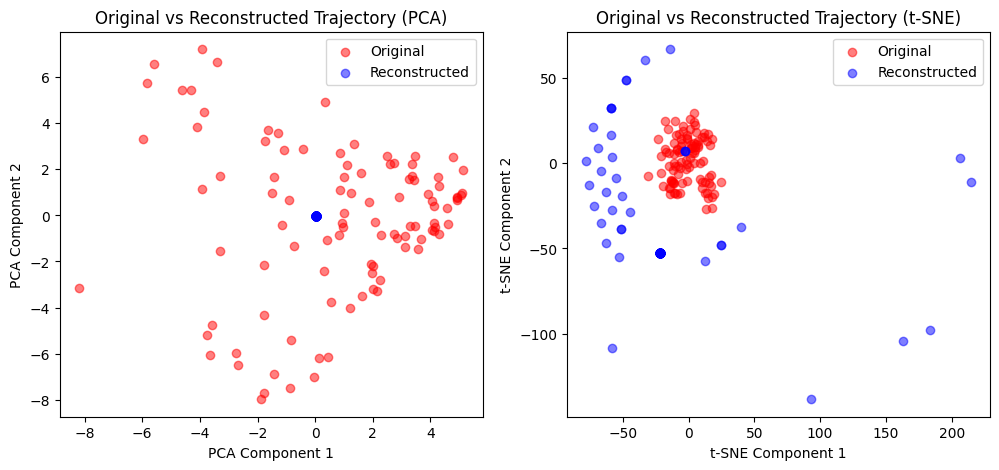

In [8]:
count = 100  # 원하는 개수

plt.figure(figsize=(12, 5))

# ✅ PCA 시각화
plt.subplot(1, 2, 1)
plt.scatter(original_pca[:count, 0], original_pca[:count, 1], alpha=0.5, color="red", label="Original")
plt.scatter(recon_pca[:count, 0], recon_pca[:count, 1], alpha=0.5, color="blue", label="Reconstructed")
plt.title("Original vs Reconstructed Trajectory (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

# ✅ t-SNE 시각화
plt.subplot(1, 2, 2)
plt.scatter(original_tsne[:count, 0], original_tsne[:count, 1], alpha=0.5, color="red", label="Original")
plt.scatter(recon_tsne[:count, 0], recon_tsne[:count, 1], alpha=0.5, color="blue", label="Reconstructed")
plt.title("Original vs Reconstructed Trajectory (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()

plt.show()